In [1]:
from pathlib import Path
import sys

sys.path.insert(0, str(Path().absolute().parent))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.random import set_seed
from tensorflow.nn import moments, conv2d
from tensorflow.keras import Model, Sequential
from tensorflow.keras.metrics import AUC
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy, Poisson
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import ReLU, BatchNormalization, Conv2D, Add, Input, AveragePooling2D, MaxPooling2D, Flatten, Dense, ReLU, ELU

In [3]:
from settings import PATH, SETTINGS
from data_convert import retarget_data_approach_2

In [11]:
retarget_data_approach_2(0)

In [5]:
%%time
set_seed(SETTINGS['random_seed'])
datagen_pars0 = {'width_shift_range': 0.2, 'height_shift_range': 0.2,
                 'shear_range': 0.2, 'zoom_range': 0.2, 'fill_mode': 'reflect',
                 'horizontal_flip': True, 'vertical_flip': True}
datagen_pars = {'target_size': SETTINGS['image_shape_for_amp_2'], 'batch_size': 16*4,
                'class_mode': 'sparse', 'seed': SETTINGS['random_seed'],
                'color_mode': 'grayscale'}
dg = ImageDataGenerator(validation_split=0.2, **datagen_pars0)
path = PATH['data']['amp_2']['generated']
df = pd.read_csv(path / SETTINGS['labels_file_name'], dtype=str)
df[SETTINGS['labels_id']] = df[SETTINGS['labels_id']].apply(lambda x: x + SETTINGS['base_format_for_amp_2'])
train_datagen_flow = dg.flow_from_dataframe(df, x_col=SETTINGS['labels_id'], y_col=SETTINGS['labels_label'],
                                            directory=path, subset='training', **datagen_pars)
val_datagen_flow = dg.flow_from_dataframe(df, x_col=SETTINGS['labels_id'], y_col=SETTINGS['labels_label'],
                                          directory=path, subset='validation', **datagen_pars)

Found 35740 validated image filenames belonging to 2 classes.


C:\ProgramData\Anaconda3\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 6 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(


Found 8934 validated image filenames belonging to 2 classes.
Wall time: 1.72 s


C:\ProgramData\Anaconda3\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 6 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(


In [6]:
def relu_bn(inputs):
    # relu = ReLU()(inputs)
    relu = ELU()(inputs)
    # return BatchNormalization()(relu)
    return relu

def residual_block(x, strides, filters, kernel_size=3):
    y = Conv2D(kernel_size=kernel_size,
               strides=strides,
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if strides > 1:
        x = Conv2D(kernel_size=2,
                   strides=strides,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out 

shape = SETTINGS['image_shape_for_amp_2'] + (1, )
inputs = Input(shape=shape)

num_blocks_list = [1] * 5
first_conv_kernel = 7
num_filters = 16

# num_blocks_list = [3] * 3
# first_conv_kernel = 7
# num_filters = 32

# num_blocks_list = [2] * 4
# first_conv_kernel = 7
# num_filters = 32

# Stemming
t = BatchNormalization()(inputs)
t = Conv2D(kernel_size=first_conv_kernel,
           strides=1,
           filters=num_filters,
           padding="same")(t)
t = relu_bn(t)

# Blocks
for i in range(len(num_blocks_list)):
    num_blocks = num_blocks_list[i]
    if shape[0] % 2 == 0:
        strides = 2
    elif shape[0] % 3 == 0:
        strides = 3
    elif shape[0] % 5 == 0:
        strides = 5
    else:
        strides = 1
    for j in range(num_blocks):
        real_strides = strides if (j==0 and i!=0) else 1
        t = residual_block(t, strides=real_strides, filters=num_filters)
    shape = [shape[0] / real_strides, shape[1] / real_strides, shape[2]]
    num_filters *= 2

# Ending
# if strides < 5:
#     t = MaxPooling2D(strides)(t)
t = Flatten()(t)
# t = Dense(10, activation='elu')(t)
# t = Dense(10, activation='elu')(t)
t = Dense(10, activation='elu')(t)
outputs = Dense(1, activation='sigmoid')(t)

model = Model(inputs, outputs)
model.compile(loss=BinaryCrossentropy(), optimizer=Adam(learning_rate=1e-5), metrics=AUC())
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 360, 1  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 180, 360, 1)  4          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 180, 360, 16  800         ['batch_normalization[0][0]']    
                                )                                                             

In [7]:
# model = Sequential()
# filters = 64
# model.add(Conv2D(input_shape=SETTINGS['image_shape_for_amp_2'] + (1, ), filters=filters, kernel_size=(3,3), padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
# filters *= 2

# model.add(Conv2D(filters=filters, kernel_size=(3,3), padding='same'))
# model.add(MaxPooling2D(pool_size=(3, 3), strides=3))
# filters *= 2

# model.add(Conv2D(filters=filters, kernel_size=(3,3), padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
# filters *= 2

# model.add(Flatten())
# model.add(Dense(5, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

# # model.compile(loss=BinaryCrossentropy(), optimizer=Adam(learning_rate=1e-4), metrics=AUC())
# model.compile(loss=BinaryCrossentropy(), optimizer=RMSprop(learning_rate=1e-5), metrics=AUC())

# model.summary()

In [8]:
%%time
steps_e = int(len(train_datagen_flow) / 4)
steps_val = int(len(val_datagen_flow) / 10)

steps_e = 10
steps_val = steps_e // 2

history = model.fit(train_datagen_flow,
                    validation_data=val_datagen_flow,
                    steps_per_epoch=steps_e,
                    validation_steps=steps_val,
                    epochs=40,
                    workers=1,
                    use_multiprocessing=False)

Epoch 1/40
10/10 [==============================] - 38s 4s/step - loss: 0.6617 - auc: 0.5938 - val_loss: 0.4529 - val_auc: 0.4121
Epoch 2/40
10/10 [==============================] - 37s 4s/step - loss: 0.5437 - auc: 0.8167 - val_loss: 0.5813 - val_auc: 0.5461
Epoch 3/40
10/10 [==============================] - 38s 4s/step - loss: 0.4376 - auc: 0.9198 - val_loss: 0.7484 - val_auc: 0.6481
Epoch 4/40
10/10 [==============================] - 37s 4s/step - loss: 0.4014 - auc: 0.8853 - val_loss: 0.8459 - val_auc: 0.6252
Epoch 5/40
10/10 [==============================] - 37s 4s/step - loss: 0.3305 - auc: 0.9127 - val_loss: 0.8442 - val_auc: 0.5357
Epoch 6/40
10/10 [==============================] - 37s 4s/step - loss: 0.2903 - auc: 0.9235 - val_loss: 1.1506 - val_auc: 0.5481
Epoch 7/40
10/10 [==============================] - 36s 4s/step - loss: 0.2801 - auc: 0.9173 - val_loss: 1.0301 - val_auc: 0.5341
Epoch 8/40
10/10 [==============================] - 36s 4s/step - loss: 0.3052 - auc: 0.90

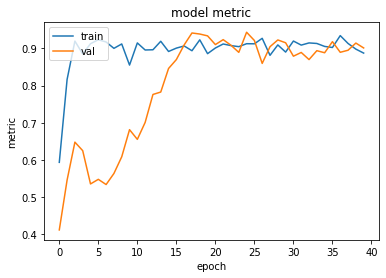

auc mean: 0.9098684966564179 val_auc mean: 0.8939553022384643


In [9]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model metric')
plt.ylabel('metric')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
n = 10
print('auc mean:', np.mean(history.history['auc'][-n:]), 'val_auc mean:', np.mean(history.history['val_auc'][-n:]),)
# auc mean: 0.6872370123863221 val_auc mean: 0.6777962684631348
# auc mean: 0.6852942168712616 val_auc mean: 0.6823923110961914
# auc mean: 0.6649937331676483 val_auc mean: 0.6567916810512543 5 * 3, f32, dense 10
# auc mean: 0.6580838203430176 val_auc mean: 0.6711127877235412 2 * 5, f16, dense 10
# auc mean: 0.6591767907142639 val_auc mean: 0.6360357999801636 2 * 5, f32, dense 10
# auc mean: 0.6760884344577789 val_auc mean: 0.6716273486614227 3 * 2, f16, dense 10
# auc mean: 0.6731 val_auc mean: 0.6595                         3 * 2, f32, dense 10
# auc mean: 0.6791764855384826 val_auc mean: 0.6656414270401001 1 * 5, f16, dense 10
# auc mean: 0.6625980615615845 val_auc mean: 0.6997840940952301 1 * 5, f16, dense 10
# auc mean: 0.6801453769207001 val_auc mean: 0.6718648612499237 1 * 5, f32, dense 10
# auc mean: 0.6693392276763916 val_auc mean: 0.6810727536678314 1 * 5, f16, dense 5+5
# auc mean: 0.6745125591754914 val_auc mean: 0.674954754114151  1 * 5, f16, dense 5+5, wo last maxpooling
# auc mean: 0.6710416615009308 val_auc mean: 0.6786670088768005 1 * 5, f16, dense 10+5, wo last maxpooling
# auc mean: 0.6707346200942993 val_auc mean: 0.6545486629009247 1 * 5, f16, dense 5+5, batchnorm
# auc mean: 0.6572491705417634 val_auc mean: 0.6580930113792419 1 * 5, f16, dense 10+10, wo last maxpooling
# auc mean: 0.6576663672924041 val_auc mean: 0.6625057339668274 1 * 5, f16, dense 10, wo last maxpooling, full data
# auc mean: 0.9098684966564179 val_auc mean: 0.8939553022384643 1 * 5, f16, dense 10, wo last maxpooling, full data, edge 50

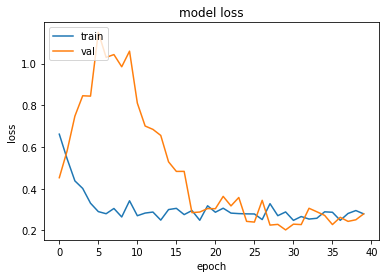

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()